# Required Libraries

In [7]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from pprint import pprint
import numpy as np

# Dataset
Load the dataset and print the classes

In [8]:
# Load the Reuters dataset
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

classes = list(newsgroups_train.target_names)
pprint(classes) # 20 classi

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Let's see the first example. It's a letter form.

In [9]:
print("SHAPE ", newsgroups_train.filenames.shape)
print("----------------------------------------")
print(newsgroups_train.data[0])
print("----------------------------------------")
print(newsgroups_train.target[0], "=>", classes[newsgroups_train.target[0]])

SHAPE  (11314,)
----------------------------------------
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
----------------------------------------
7 => rec.autos


# Preprocessing

Preprocess every example: remove stopwords and compute the Tf-idf vector representation.

In [10]:
# Extract features from the dataset
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

Let's see what's inside after the transformation

In [11]:
print(X_train[0])
print(X_train.shape)
print(len(newsgroups_train.data), len(vectorizer.vocabulary_))

  (0, 59071)	0.10043853867312116
  (0, 57250)	0.1063473585616558
  (0, 41874)	0.224548896412017
  (0, 49800)	0.11869932893481257
  (0, 46690)	0.12504220873599214
  (0, 73174)	0.16142029533900565
  (0, 99608)	0.09418459052541318
  (0, 84050)	0.16329311028814825
  (0, 37208)	0.1434127293323407
  (0, 62594)	0.13037295035007848
  (0, 87913)	0.25808578247347563
  (0, 54493)	0.06961997844491917
  (0, 23430)	0.12937103288512333
  (0, 77676)	0.12197186951739486
  (0, 81450)	0.1461308934288897
  (0, 24583)	0.19644480500804062
  (0, 16806)	0.1407774554706102
  (0, 83208)	0.11339406589538423
  (0, 76269)	0.08978258481915573
  (0, 34742)	0.17300821242559045
  (0, 24108)	0.24723134514216435
  (0, 25437)	0.10548299054214269
  (0, 11174)	0.20599311323287353
  (0, 35902)	0.1266709604197344
  (0, 9843)	0.20797700857530224
  (0, 55606)	0.13822596989753821
  (0, 57247)	0.1352084247105906
  (0, 84312)	0.16368392505928514
  (0, 34741)	0.14847880131844235
  (0, 31927)	0.10526008886822914
  (0, 80420)	0.1270

Each dimension corresponds to a word in the original text. For example:

In [12]:
print(vectorizer.get_feature_names_out()[25717], X_train[0, 25717])
print(vectorizer.get_feature_names_out()[80420], X_train[0, 80420])

car 0.46579831435138974
saw 0.127069039671221


# Rocchio Model

Secondo il modello di Rocchio, una parola (che nel vocabolario ha indice $w$) ha un peso $\Omega_w^i$ nella categoria $C_i$ definito così:
$$ \Omega_w^i = max\{0, \frac{\beta}{|T_i|}\sum_{d \in T_i} \omega_w^d - \frac{\gamma}{|\bar{T}_i|}\sum_{d \in \bar{T}_i} \omega_w^d\} $$

- $\omega_w^d$ è il peso o importanza tf-idf per la parola $w$ (indice del vocabolario) nel documento d rispetto a tutto il corpus. 
- I documenti $d$ vengono suddivisi in due sottoinsiemi disgiunti:
    - $T_i$ sono i documenti che appartengono alla classe $i$ del training set.
    - $\bar{T}_i$ sono i documenti che NON appartengono alla classe $i$ del training set.
- $\beta$ è il peso per l'evidenza POSITIVA, ovvero che la parola faccia parte della classe $i$.
- $\gamma$ è il peso per l'evidenza NEGATIVA, ovvero che la parola NON faccia parte della classe $i$.
- Più aumentiamo $\beta$ rispetto a $gamma$ epiù viene data importanza all'evidenza POSITIVA, quindi si potrebbero avere dei falsi positivi.
- Più aumentiamo $\gamma$, meno peso viene dato ai termini poco rilevanti.

Se il vocabolario ha dimensione $M$, definiamo:
- i **vettori categoria**, ovvero la lista di pesi che ciascuna parola  ha per appartenere a una determinata classe. Se il peso per una parola è positivo, c'è un'evidenza POSITIVA che la classe contiene parole del genere.
$$(\Omega_1^i, ..., \Omega_M^i)^T$$
- i **vettori documento**, ovvero i vettori tf-idf di ogni parola del vocabolario, che rappresentano un documento. Se il punteggio tf-idf per una parola è elevato, allora quella parola è più importante di altre per questo documento.
$$(\omega_1^i, ..., \omega_M^i)^T$$

Il modello di Rocchio è debole alle **categorie polimorfiche**, ovvero quando il vettore che rappresenta una parola ha una distanza angolare (cosine similarity) che la rende più vicina alla categoria sbagliata.

In [13]:
# Define the Rocchio Algorithm function
def rocchio_model(X_train, y_train, beta=1, gamma=1):

  # Calculate the centroid for each class
  centroids = np.zeros((len(np.unique(y_train)), X_train.shape[1]))
  for i, label in enumerate(np.unique(y_train)):
    centroids[i] = X_train[y_train == label].mean(axis=0)

  # Calculate the prototype for each class (sono dei vettori)
  prototypes = np.zeros((len(np.unique(y_train)), X_train.shape[1]))
  for i, label in enumerate(np.unique(y_train)):
    prototypes[i] = beta * (X_train[y_train == label].sum(axis=0) - centroids[i]) / X_train[y_train == label].getnnz() \
                    - gamma * X_train[y_train != label].sum(axis=0) / X_train[y_train != label].getnnz()

  return prototypes

def test(rocchio_model, X_test):
  # Make predictions on the test set
  y_pred = []
  for doc in X_test:
    similarities = np.zeros(len(rocchio_model))
    for i, prototype in enumerate(rocchio_model):
      similarities[i] = cosine_similarity(doc.toarray().flatten().reshape(1, -1), prototype.flatten().reshape(1, -1))

    # store only the value of the class maximized by the similarity
    y_pred.append(np.argmax(similarities))

  return y_pred

## Test the model

Test the model with default parameters. Notice that for sake of brevity, the test set is limited to the first 500 (`X_test[:500]`) instances. You will need to evaluate the models on the entire test set.

In [9]:
# get the model
rocchio_prototypes = rocchio_model(X_train, y_train)
print(rocchio_prototypes.shape)

# Make predictions on the test set
y_pred = test(rocchio_prototypes, X_test[:500])

# Print the classification report and confusion matrix
print(classification_report(y_test[:500], y_pred, target_names=newsgroups_test.target_names))

(20, 101322)
                          precision    recall  f1-score   support

             alt.atheism       0.22      0.48      0.30        21
           comp.graphics       0.44      0.76      0.56        21
 comp.os.ms-windows.misc       0.60      0.35      0.44        26
comp.sys.ibm.pc.hardware       0.46      0.56      0.51        34
   comp.sys.mac.hardware       0.68      0.74      0.70        34
          comp.windows.x       0.79      0.73      0.76        26
            misc.forsale       0.72      0.59      0.65        22
               rec.autos       0.72      0.82      0.77        28
         rec.motorcycles       0.76      0.76      0.76        33
      rec.sport.baseball       0.82      0.92      0.87        25
        rec.sport.hockey       0.96      0.85      0.90        27
               sci.crypt       0.79      0.55      0.65        20
         sci.electronics       0.44      0.67      0.53        24
                 sci.med       0.79      0.48      0.59       

Test the model with `beta=1, gamma=10`. The negative examples are more important.

In [10]:
# get the model
prototypes = rocchio_model(X_train, y_train, beta=1, gamma=10)

# Make predictions on the test set
y_pred = test(prototypes, X_test[:500])

# Print the classification report and confusion matrix
print(classification_report(y_test[:500], y_pred, target_names=newsgroups_test.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.17      0.29      0.21        21
           comp.graphics       0.57      0.76      0.65        21
 comp.os.ms-windows.misc       0.67      0.46      0.55        26
comp.sys.ibm.pc.hardware       0.49      0.62      0.55        34
   comp.sys.mac.hardware       0.60      0.74      0.66        34
          comp.windows.x       0.79      0.73      0.76        26
            misc.forsale       0.56      0.64      0.60        22
               rec.autos       0.73      0.79      0.76        28
         rec.motorcycles       0.76      0.79      0.78        33
      rec.sport.baseball       0.81      0.88      0.85        25
        rec.sport.hockey       0.86      0.93      0.89        27
               sci.crypt       0.76      0.65      0.70        20
         sci.electronics       0.71      0.42      0.53        24
                 sci.med       0.80      0.70      0.74        23
         

Test the model with `beta=10, gamma=1`. Positive examples are more important here.

In [11]:
# get the model
prototypes = rocchio_model(X_train, y_train, beta=10, gamma=1)

# Make predictions on the test set
y_pred = test(prototypes, X_test[:500])

# Print the classification report and confusion matrix
print(classification_report(y_test[:500], y_pred, target_names=newsgroups_test.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.17      0.33      0.23        21
           comp.graphics       0.48      0.76      0.59        21
 comp.os.ms-windows.misc       0.62      0.58      0.60        26
comp.sys.ibm.pc.hardware       0.56      0.56      0.56        34
   comp.sys.mac.hardware       0.81      0.62      0.70        34
          comp.windows.x       0.82      0.69      0.75        26
            misc.forsale       0.72      0.59      0.65        22
               rec.autos       0.85      0.82      0.84        28
         rec.motorcycles       0.93      0.76      0.83        33
      rec.sport.baseball       0.91      0.80      0.85        25
        rec.sport.hockey       0.83      0.89      0.86        27
               sci.crypt       0.81      0.65      0.72        20
         sci.electronics       0.50      0.62      0.56        24
                 sci.med       0.89      0.74      0.81        23
         

## EXERCISE: Find the best parameters

Now it's your turn. Find the best parameters `beta` and `gamma` in order to maximize somehow the overall F1-measure.  

**Hint**: use a *grid search* by defining 2 `for` loops and save the values of the params; then plot the result in a graphic, discuss it brefly and write some conclusions.

1. Run the Rocchio model over a set of different parameter pair (beta, gamma)
2. Plot as shown in the previous practice lesso the F1 measure achieved with the diffferent settings (useplt or seaborn)
3. Try to modify the code (Rocchio model) to select class specific pairs (beta_i, gamma_i) for each individual i-th class

In [43]:
import inspect
print(inspect.getsource(GridSearchCV))

class GridSearchCV(BaseSearchCV):
    """Exhaustive search over specified parameter values for an estimator.

    Important members are fit, predict.

    GridSearchCV implements a "fit" and a "score" method.
    It also implements "score_samples", "predict", "predict_proba",
    "decision_function", "transform" and "inverse_transform" if they are
    implemented in the estimator used.

    The parameters of the estimator used to apply these methods are optimized
    by cross-validated grid-search over a parameter grid.

    Read more in the :ref:`User Guide <grid_search>`.

    Parameters
    ----------
    estimator : estimator object
        This is assumed to implement the scikit-learn estimator interface.
        Either estimator needs to provide a ``score`` function,
        or ``scoring`` must be passed.

    param_grid : dict or list of dictionaries
        Dictionary with parameters names (`str`) as keys and lists of
        parameter settings to try as values, or a list of su

In [29]:
class Rocchio_F1score:
    def __init__(self, beta: float, gamma: float, f1: float):
        self.beta = beta
        self.gamma = gamma
        self.f1 = f1

    def beta_gamma(self):
        return "Beta: " + str(self.beta) + " Gamma: " + str(self.gamma)

    def __str__(self):
        return "Beta: " + str(self.beta) + " Gamma: " + str(self.gamma) + " f1: " + str(self.f1)

    def __repr__(self):
        return "(Beta: " + str(self.beta) + " Gamma: " + str(self.gamma) + " f1: " + str(self.f1) + ")"

    def __gt__(self, rocchio2: Rocchio_F1score):
        return self.f1 > rocchio2.f1

    def __lt__(self, rocchio2: Rocchio_F1score):
        return self.f1 < rocchio2.f1

    def __eq__(self, rocchio2: Rocchio_F1score):
        return self.f1 == rocchio2.f1

    


In [65]:
from sklearn.metrics import f1_score

# fill the lists with plausible values
betas_list = [0.1, 5, 10]
gammas_list = [0.1, 5, 10]

best_rocchio = Rocchio_F1score(0.0, 0.0, 0.0)

rocchio_list = []

for beta in betas_list:
    for gamma in gammas_list:

        rocchio_prototypes = rocchio_model(
            X_train, y_train, beta=beta, gamma=gamma)

        # Make predictions on the test set
        y_pred = test(rocchio_prototypes, X_test[:500])

        # Print the classification report and confusion matrix
        f1 = f1_score(y_test[:500], y_pred, average='weighted')

        rocchio = Rocchio_F1score(beta, gamma, f1)
        rocchio_list.append(rocchio)
        
        if rocchio > best_rocchio:
            best_rocchio = rocchio


KeyboardInterrupt: 

In [32]:
print(best_rocchio)
print(rocchio_list)

Beta: 5 Gamma: 0.1 f1: 0.6841542350824499
[(Beta: 0.1 Gamma: 0.1 f1: 0.644116085418252), (Beta: 0.1 Gamma: 5 f1: 0.6564194137014819), (Beta: 0.1 Gamma: 10 f1: 0.6479117042642492), (Beta: 5 Gamma: 0.1 f1: 0.6841542350824499), (Beta: 5 Gamma: 5 f1: 0.644116085418252), (Beta: 5 Gamma: 10 f1: 0.5851286896602356), (Beta: 10 Gamma: 0.1 f1: 0.6841542350824499), (Beta: 10 Gamma: 5 f1: 0.6713875609544332), (Beta: 10 Gamma: 10 f1: 0.644116085418252)]


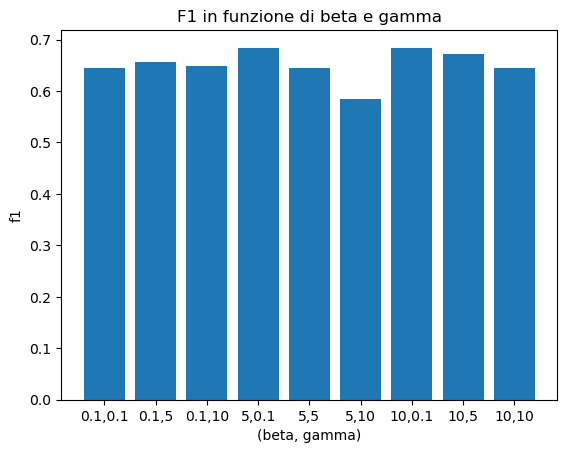

In [64]:
from matplotlib import pyplot as plt
# here make a plot as shown in the previous practice lesson with plt or seaborn.

beta_gammas = map(lambda r: str(r.beta) +","+ str(r.gamma), rocchio_list)
# gammas = map(lambda r: r.gamma, rocchio_list)
f1s = map(lambda r: r.f1, rocchio_list)

plt.bar(height=list(f1s), x=list(beta_gammas))
plt.title("F1 in funzione di beta e gamma")
plt.xlabel("(beta, gamma)")
plt.ylabel("f1")
plt.show()


In [ ]:
# TODO: Try to modify the code (Rocchio model) to select class specific pairs (beta_i, gamma_i) for each individual i-th class
